In [ ]:
!pip install pytorch-lightning torch transformers optuna pandas numpy scikit-learn seaborn matplotlib gpyopt wandb pyyaml optuna-integration[pytorch_lightning] sympy
!pip install shap lion-pytorch sentence-transformers #pytorch-quantization optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 13.4 MB/s eta 0:00:0

YAML file created at: config_lr_finder_advanced.yaml


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LR Finder: 100%|██████████| 10000/10000 [28:16<00:00,  5.90it/s]


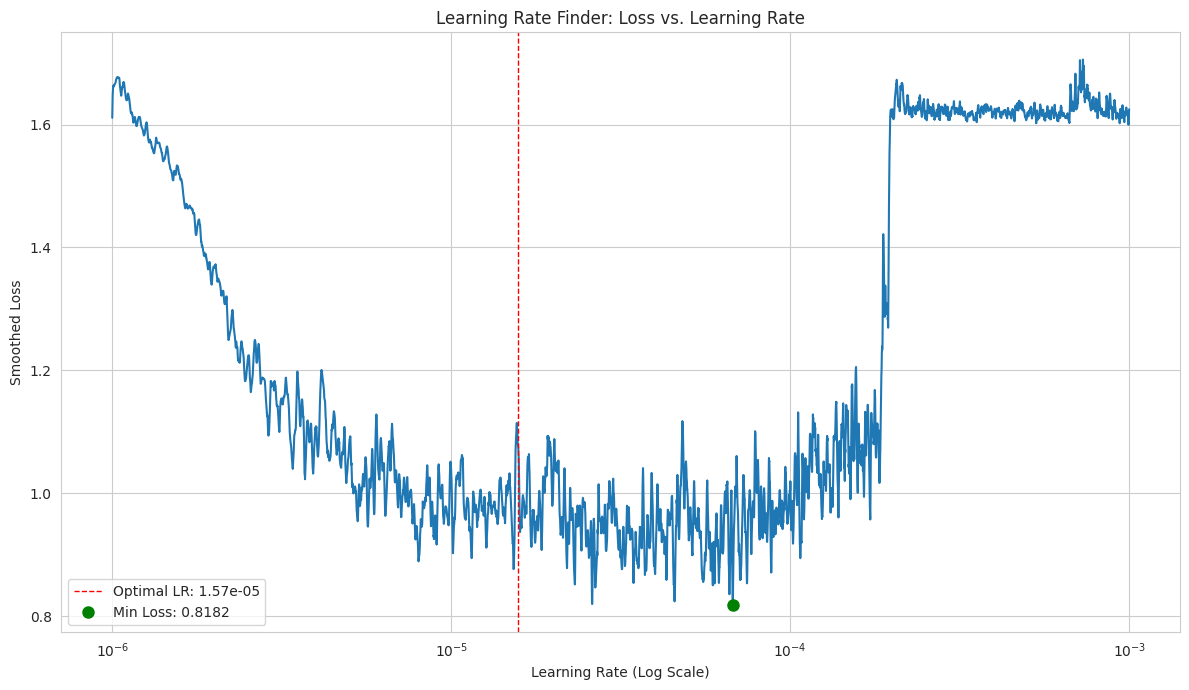

Optimal learning rate: 1.57e-05


In [ ]:
import torch
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import yaml
from pathlib import Path
import logging
import numpy as np  # For robust statistics (e.g., median)
import os  # For config file path handling

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - [%(funcName)s] - %(message)s')
logger = logging.getLogger(__name__)

class LRFinderDataset(Dataset):
    # ... (Dataset class remains the same) ...
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

class StandaloneLRFinder:
    def __init__(self, config_path="config.yaml", config_override=None):
        self.default_config = { # Default configuration
            'lr_finder': {
                'end_lr': 0.1,
                'num_iter': 200,
                'smooth_factor': 0.05,
                'divergence_threshold_factor': 4.0,
                'gradient_suggestion': True,
                'batch_loss_averaging_iterations': 5,
                'adaptive_num_iter_factor': 1.5,
                'min_num_iter': 100,
                'divergence_gradient_threshold': 0.1, # Threshold for gradient-based divergence
                'ema_beta': 0.98,
                'robust_statistics': True, # Use median for loss averaging
                'initial_lr': 1e-7
            },
            'data_module': { # Example data module settings - can be overridden in config.yaml
                'data_dir': "data",
                'data_path': "/content/so_many_rev.csv",
                'model_name': "bert-base-uncased",
                'max_length': 128,
                'batch_size': 16,
                'num_workers': 2
            },
            'model_name': "bert-base-uncased", # Example model name
            'num_labels': 5 # Example num_labels
        }
        self.config = self._load_config(config_path, config_override)
        self.data_dir = Path(self.config['data_module'].get('data_dir', 'data'))
        self.data_dir.mkdir(parents=True, exist_ok=True)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.config['data_module'].get('model_name', 'bert-base-uncased'),
            cache_dir="./model_cache"
        )

        # Set parameters from config (LR Finder specific)
        self.lr_finder_config = self.config['lr_finder']
        self.end_lr = self.lr_finder_config['end_lr']
        self.num_iter = self.lr_finder_config['num_iter']
        self.smooth_factor = self.lr_finder_config['smooth_factor']
        self.divergence_threshold_factor = self.lr_finder_config['divergence_threshold_factor']
        self.use_gradient_suggestion = self.lr_finder_config['gradient_suggestion']
        self.batch_loss_averaging_iterations = self.lr_finder_config['batch_loss_averaging_iterations']
        self.adaptive_num_iter_factor = self.lr_finder_config['adaptive_num_iter_factor']
        self.min_num_iter = self.lr_finder_config['min_num_iter']
        self.divergence_gradient_threshold = self.lr_finder_config['divergence_gradient_threshold']
        self.ema_beta = self.lr_finder_config['ema_beta']
        self.use_robust_statistics = self.lr_finder_config['robust_statistics']
        self.initial_lr = self.lr_finder_config['initial_lr']


        # Set parameters from config (Data Module)
        self.max_length = self.config['data_module'].get('max_length', 128)
        self.batch_size = self.config['data_module'].get('batch_size', 32)
        self.num_workers = self.config['data_module'].get('num_workers', 4)

        # Prepare data
        self.train_dataset = None
        self._prepare_data()

    def _load_config(self, config_path, config_override):
        config = self.default_config.copy() # Start with defaults
        if config_path and os.path.exists(config_path):
            with open(config_path, 'r') as f:
                file_config = yaml.safe_load(f)
                if file_config:
                    config.update(file_config) # Update with file config
        if config_override:
            config.update(config_override) # Override with programmatic config
        return config


    def _prepare_data(self):
        data_path = self.config['data_module'].get('data_path')
        if not data_path or not Path(data_path).exists():
            raise FileNotFoundError(f"Data file not found at: {data_path}")

        df = pd.read_csv(data_path)
        df["label"] = df["rating"].astype(int) - 1

        # Split data and create training dataset
        train_texts, _, train_labels, _ = train_test_split(
            df["text"].tolist(),
            df["label"].to_numpy(),
            test_size=0.2,
            random_state=42,
            stratify=df["label"].to_numpy()
        )

        self.train_dataset = LRFinderDataset(
            train_texts,
            train_labels,
            self.tokenizer,
            self.max_length
        )

    def get_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True
        )

    def find_lr(self, model=None, optimizer=None, criterion=None, end_lr_override=None, num_iter_override=None):
        """
        Finds the optimal learning rate range.

        Args:
            model: PyTorch model. If None, initializes from config.
            optimizer: PyTorch optimizer. If None, initializes AdamW with initial_lr from config.
            criterion: Loss function. If None, defaults to CrossEntropyLoss (adjust if needed).
            end_lr_override (float, optional): Override end_lr from config. Defaults to None.
            num_iter_override (int, optional): Override num_iter from config. Defaults to None.

        Returns:
            float: Optimal learning rate.
            dict: History of learning rates and losses.
        """
        # Initialize model, optimizer, criterion if not provided
        if model is None:
            model = AutoModelForSequenceClassification.from_pretrained(
                self.config['model_name'],
                num_labels=self.config['num_labels'],
                cache_dir="./model_cache"
            ).to(self.device)
        if optimizer is None:
            optimizer = torch.optim.AdamW(model.parameters(), lr=self.initial_lr) # Use initial_lr from config
        if criterion is None:
            criterion = torch.nn.CrossEntropyLoss() # Default criterion, adjust if needed

        # Override end_lr and num_iter if provided
        end_lr = end_lr_override if end_lr_override is not None else self.end_lr
        num_iter = num_iter_override if num_iter_override is not None else self.num_iter

        history = {"lr": [], "loss": []}
        best_loss = None
        diverged = False
        divergence_iteration = -1 # Track iteration where divergence occurs

        lr_lambda = lambda x: math.exp(x * math.log(end_lr / optimizer.param_groups[0]['lr']) / num_iter)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

        train_loader = self.get_dataloader()
        train_iter = iter(train_loader)
        smoothed_loss = None
        ema_beta = self.ema_beta
        avg_loss = 0.0
        iteration_count = 0
        loss_history_batch = [] # Store batch losses for averaging


        model.train()
        with tqdm(total=num_iter, desc="LR Finder") as pbar:
            for iteration in range(num_iter):
                iteration_count += 1
                try:
                    batch = next(train_iter)
                except StopIteration:
                    train_iter = iter(train_loader)
                    batch = next(train_iter)

                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                optimizer.zero_grad()
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

                if torch.isfinite(loss):
                    loss.backward()
                    optimizer.step()

                current_lr = scheduler.get_last_lr()[0]
                current_loss = loss.item()

                loss_history_batch.append(current_loss)
                if len(loss_history_batch) > self.batch_loss_averaging_iterations:
                    loss_history_batch.pop(0) # Keep last N batch losses

                # Robust statistics for loss averaging (median or mean)
                if self.use_robust_statistics:
                    current_loss_averaged = float(np.median(loss_history_batch))
                else:
                    current_loss_averaged = sum(loss_history_batch) / len(loss_history_batch)

                # EMA Smoothing with Bias Correction
                avg_loss = ema_beta * avg_loss + (1 - ema_beta) * current_loss_averaged
                smoothed_loss = avg_loss / (1 - ema_beta**iteration_count) # Bias correction


                history["lr"].append(current_lr)
                history["loss"].append(smoothed_loss)

                if best_loss is None or smoothed_loss < best_loss:
                    best_loss = smoothed_loss
                elif self._check_divergence(smoothed_loss, best_loss, history['loss'], iteration): # Check for divergence
                    diverged = True
                    divergence_iteration = iteration
                    break # Stop if diverged

                scheduler.step()
                pbar.update(1)

        optimal_lr = self._suggest_lr(history, diverged, divergence_iteration) # Suggest LR
        report = self._generate_report(optimal_lr, history, best_loss, diverged, divergence_iteration, end_lr, num_iter) # Generate report

        if self.adaptive_num_iter_factor and not diverged and iteration_count >= num_iter and num_iter < self.min_num_iter * 5: # Adapt num_iter if not diverged and reached max iterations (up to 5x min_num_iter)
            logger.info(f"No divergence detected, increasing num_iter to {int(num_iter * self.adaptive_num_iter_factor)}")
            return self.find_lr(model=model, optimizer=optimizer, criterion=criterion, end_lr_override=end_lr, num_iter_override=int(num_iter * self.adaptive_num_iter_factor)) # Recursive call with increased iterations

        self._plot_curve(history, optimal_lr, best_loss, diverged, divergence_iteration) # Plot with optimal LR annotation
        logger.info(report) # Log the report
        return optimal_lr, history

    def _check_divergence(self, current_loss, best_loss, loss_history, iteration):
        """Robust divergence check using loss threshold and gradient."""
        if current_loss > self.divergence_threshold_factor * best_loss: # Loss threshold divergence
            return True

        if iteration > 10: # Check gradient only after some iterations
            recent_losses = loss_history[-10:] # Check gradient over last 10 losses
            loss_gradient = (recent_losses[-1] - recent_losses[0]) / 10 # Simple gradient
            if loss_gradient > self.divergence_gradient_threshold: # Gradient threshold divergence
                return True
        return False


    def _suggest_lr(self, history, diverged, divergence_iteration):
        """Suggest optimal LR based on gradient or minimum loss, handling divergence."""
        if self.use_gradient_suggestion:
            return self._suggest_lr_gradient(history)
        else:
            return self._suggest_lr_min_loss(history, diverged, divergence_iteration)


    def _suggest_lr_gradient(self, history):
        """Suggest LR based on maximum negative gradient (refined)."""
        losses = history["loss"]
        lrs = history["lr"]
        gradients = []
        smooth_gradients = []
        gradient_smoothing_factor = 0.8 # Smoothing factor for gradients
        last_smooth_grad = 0

        for i in range(1, len(losses)):
            gradient = (losses[i] - losses[i-1]) / (math.log10(lrs[i]) - math.log10(lrs[i-1])) if lrs[i] != lrs[i-1] else 0 # Log scale for LR
            gradients.append(gradient)
            smooth_grad = gradient * (1 - gradient_smoothing_factor) + last_smooth_grad * gradient_smoothing_factor # EMA for gradients
            smooth_gradients.append(smooth_grad)
            last_smooth_grad = smooth_grad


        if not smooth_gradients:
            return history['lr'][0] / 10 if history['lr'] else 1e-6 # Return initial LR if no gradients

        min_grad_idx = smooth_gradients.index(min(smooth_gradients)) # Index of most negative smoothed gradient
        optimal_lr = lrs[min_grad_idx + 1] / 10 if min_grad_idx + 1 < len(lrs) else lrs[min_grad_idx] / 10 # LR one step after min gradient, divided by 10, or at min_grad if last point

        return optimal_lr


    def _suggest_lr_min_loss(self, history, diverged, divergence_iteration):
        """Suggest LR based on minimum loss, considering divergence point."""
        losses = history["loss"]
        lrs = history["lr"]

        if diverged:
            divergence_idx = divergence_iteration
            if divergence_idx > 10: # Use LR slightly before divergence if diverged reasonably late
                return lrs[max(0, divergence_idx - 10)]
            else: # If diverged very early, return a very small LR
                return lrs[0] / 10

        min_loss_idx = losses.index(min(losses))
        return lrs[max(0, min_loss_idx - 5)] # Return LR slightly before min loss, smaller offset


    def _generate_report(self, optimal_lr, history, best_loss, diverged, divergence_iteration, end_lr, num_iter):
        """Generate a textual report of the LR finder run."""
        report = "\n--- Learning Rate Finder Report ---"
        report += f"\nOptimal Learning Rate: {optimal_lr:.2e}"
        report += f"\nBest Loss: {best_loss:.4f}"
        report += f"\nExplored LR Range: [{history['lr'][0]:.2e}, {history['lr'][-1]:.2e}] (up to {end_lr:.2e})"
        report += f"\nNumber of Iterations: {len(history['lr'])} (Target: {num_iter})"
        if diverged:
            report += f"\nDivergence Detected at Iteration: {divergence_iteration}"
        else:
            report += "\nDivergence: No divergence detected within the explored range."
        if self.use_gradient_suggestion:
            report += "\nLR Suggestion Method: Gradient-based"
        else:
            report += "\nLR Suggestion Method: Minimum Loss-based"
        report += "\n--- End Report ---"
        return report

    def _plot_curve(self, history, optimal_lr, best_loss, diverged, divergence_iteration):
        """Plotting the learning rate vs. loss curve with annotations."""
        plt.figure(figsize=(12, 7)) # Larger figure size
        sns.set_style("whitegrid")

        lrs = history["lr"]
        losses = history["loss"]

        sns.lineplot(x=lrs, y=losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate (Log Scale)') # More descriptive labels
        plt.ylabel('Smoothed Loss')
        plt.title('Learning Rate Finder: Loss vs. Learning Rate')

        # Annotate Optimal LR
        plt.axvline(x=optimal_lr, color='r', linestyle='--', linewidth=1, label=f'Optimal LR: {optimal_lr:.2e}') # Dashed red line for optimal LR

        # Annotate Best Loss
        min_loss_y = min(losses)
        min_loss_x_idx = losses.index(min_loss_y)
        min_loss_x = lrs[min_loss_x_idx]
        plt.plot(min_loss_x, min_loss_y, 'go', markersize=8, label=f'Min Loss: {min_loss_y:.4f}') # Green dot for min loss

        if diverged:
            divergence_lr = history['lr'][divergence_iteration]
            divergence_loss = history['loss'][divergence_iteration]
            plt.plot(divergence_lr, divergence_loss, 'rx', markersize=10, linewidth=2, label='Divergence Point') # Red 'x' for divergence

        plt.legend() # Show legend
        plt.grid(True)
        plt.tight_layout() # Adjust layout
        plt.show()


if __name__ == '__main__':
    # Example config data (adjust as needed for your setup)
    config_data = {
        'model_name': "bert-base-uncased",
        'num_labels': 5,
        'data_module': {
            'data_path': "/content/so_many_rev.csv",  # Replace with your actual data path
            'model_name': "bert-base-uncased",
            'max_length': 128,
            'batch_size': 16,
            'num_workers': 2
        },
        'lr_finder': {
            'end_lr': 1, # Adjusted end_lr
            'num_iter': 10000, # Adjusted num_iter
            'smooth_factor': 0.06, # Adjusted smooth_factor
            'divergence_threshold_factor': 10.0, # Adjusted divergence threshold
            'gradient_suggestion': True, # Use gradient-based suggestion
            'batch_loss_averaging_iterations': 10, # Increased batch loss averaging
            'adaptive_num_iter_factor': 1.8, # Increased adaptive num_iter factor
            'min_num_iter': 150, # Increased min_num_iter
            'divergence_gradient_threshold': 0.2, # Adjusted divergence gradient threshold
            'ema_beta': 0.9, # Adjusted EMA beta
            'robust_statistics': True, # Use median for loss averaging
            'initial_lr': 1e-6 # Adjusted initial LR
        }
    }

    yaml_file_path = 'config_lr_finder_advanced.yaml'
    with open(yaml_file_path, 'w') as yaml_file:
        yaml.dump(config_data, yaml_file, default_flow_style=False)
    print(f"YAML file created at: {yaml_file_path}")

    lr_finder = StandaloneLRFinder("config_lr_finder_advanced.yaml")
    optimal_lr, history = lr_finder.find_lr() # Run LR finder
    print(f"Optimal learning rate: {optimal_lr:.2e}")